In [1]:
from __future__ import print_function

import os
import statistics
import numpy as np
from numpy import expand_dims
from numpy import vstack
from numpy.random import randn
from numpy.random import randint

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Reshape, Flatten, LeakyReLU, Dropout
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.utils import plot_model

from matplotlib import pyplot as plt
from matplotlib import image
from PIL import Image

In [2]:
def DiscriminatorModel(input_shape=(128,128,3), verbose=False):
    
    model = Sequential()
    
    # downsample to 32@8x8
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=input_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    #model.add(Dropout(0.25))
    
    # downsample to 64@16x16
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    #model.add(Dropout(0.25))
    
    # downsample to 128@32x32
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    #model.add(Dropout(0.25))
    
    # downsample to 256@16x16
    model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    #model.add(Dropout(0.25))
    
    # downsample to 512@8x8
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    #model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    # compile model   
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    if verbose:
        print("DISCRIMINATOR MODEL:")
        model.summary()
        plot_model(model, to_file='d_model.png', show_shapes=True)
    
    return model

In [3]:
def GeneratorModel(latent_dim=50, verbose=False):
    model = Sequential()
    init = RandomNormal(stddev=0.02)
    
    model.add(Dense(512 * 8 * 8, activation="relu", input_dim=latent_dim))
    model.add(Reshape((8, 8, 512)))
    
    # upsample to 256@16x16
    model.add(UpSampling2D())
    model.add(Conv2D(256, kernel_size=3, padding="same"))
    #model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    
    # upsample to 128@32x32
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    #model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    
    # upsample to 64@64x64
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    #model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    
    # upsample to 32@128x128
    model.add(UpSampling2D())
    model.add(Conv2D(32, kernel_size=3, padding="same"))
    #model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    
    # merge colors to 3@128x128
    model.add(Conv2D(3, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))
  
    if verbose:
        print("GENERATOR MODEL:")
        model.summary()
        plot_model(model, to_file='g_model.png', show_shapes=True)
        
    return model

In [4]:
def GDModel(g_model, d_model, verbose=False):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    
    # compile model   
    opt = Adam(lr=0.0002, beta_1=0.5)  
    model.compile(loss='binary_crossentropy', optimizer=opt)
    
    if verbose:
        print("GD MODEL:")
        model.summary()
        plot_model(model, to_file='gd_model.png', show_shapes=True)
    
    return model

In [5]:
def LoadImageFromFile(folder, filename):
    img = image.imread(os.path.join(folder,filename))
    return img

In [6]:
def LoadImagesFromFolder(folder, filenames, verbose=False):
    if verbose:
        print(f'Loading images from {folder}...')
    images = []
    for idx in range(len(filenames)):
        if verbose:
            print(f'{int((idx/len(filenames))*100)}%', end='\r')
        fname=filenames[idx]
        img = np.array(Image.open(os.path.join(folder,fname)))
        images.append(img)
    if verbose:
        print('Done!')
    return np.array(images)

In [7]:
def TanhToNormColor(img):
    # Color in [-1,1] range transformed to [0,1] range
    return (img + 1) / 2.0

def NormToTanhColor(img):
    # Color in [0,1] range transformed to [-1,1] range
    return (img * 2.0) - 1

In [8]:
def GetFakeSamples(g_model, latent_dim, num_samples):
    x_input = randn(latent_dim * num_samples)
    x_input = x_input.reshape(num_samples, latent_dim)

    fake_samples = g_model.predict(x_input)

    # Color in range [-1,1] as we use tanh activation function
    return fake_samples

In [9]:
def GetDiscriminatorPerformance(d_model, real_samples, fake_samples):
    _, acc_real = d_model.evaluate(real_samples, np.ones(len(real_samples)), verbose=0)
    _, acc_fake = d_model.evaluate(fake_samples, np.zeros(len(fake_samples)), verbose=0)
    return acc_real, acc_fake

In [10]:
def ShowGeneratorPerformance(g_model, epoch, latent_dim, rows=3, columns=5):
    print(f'GENERATOR AT EPOCH {epoch}:')
    fig, ax = plt.subplots(nrows=rows, ncols=columns, sharex=True, sharey=True)
    for idx in range(rows):    
      for jdx in range(columns):
        rnd_lantent_point = randn(latent_dim)
        imgs = g_model.predict(np.array( [rnd_lantent_point,] ))
        ax[idx,jdx].axis('off')
        ax[idx,jdx].imshow(TanhToNormColor(imgs[0]), interpolation='nearest')
        
    filename = 'generated_plot_e%03d.png' % (epoch)
    plt.savefig(filename)

    plt.draw()
    plt.pause(0.001)

In [11]:
def PlotRealFakeComparison(real_img, fake_img):
    fig = plt.figure()
     
    ax = fig.add_subplot(1, 2, 1)
    ax.set_title('Real')
    ax.axis('off')
    imgplot = plt.imshow(TanhToNormColor(real_img))
    
    ax = fig.add_subplot(1, 2, 2)   
    ax.set_title('Fake')
    ax.axis('off')
    imgplot = plt.imshow(TanhToNormColor(fake_img))
    
    plt.draw()
    plt.pause(0.001)

In [12]:
def PlotLossA(d_loss, gd_loss):
    plt.plot(d_loss)
    plt.plot(gd_loss)
    plt.title('Loss evolution')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Discriminator', 'Generator'], loc='upper left')
    plt.show()
    
def PlotLossB(d_loss_real, d_loss_fake, gd_loss):
    plt.plot(d_loss_real)
    plt.plot(d_loss_fake)
    plt.plot(gd_loss)
    plt.title('Loss evolution')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['d-real','d-fake', 'gen'], loc='upper left')
    plt.show()
    
def PlotAccuracy(d_real_acc, d_fake_acc):
    plt.plot(d_real_acc)
    plt.plot(d_fake_acc)
    plt.title('Discriminator accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Real', 'Fake'], loc='upper left')
    plt.show()

In [13]:
def LastItem(array):
    return array[len(array)-1]

In [14]:
def SaveGeneratorModel(epoch, g_model):
    filename = f'generator_model_{epoch}.h5'
    g_model.save(filename)
    print(f'Generator model saved for epoch {epoch}!')

In [15]:
img_shape=(128,128)
batch_size = 64
epochs = 200

Train images: 8000 - Test files: 2000


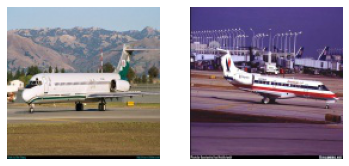

In [16]:
# LOAD REAL IMAGES

train_folder='./train/real'
test_folder='./test/real'

train_files = np.array(os.listdir(train_folder))
test_files = np.array(os.listdir(test_folder))

print(f'Train images: {len(train_files)} - Test files: {len(test_files)}')

# Plot some samples
fig = plt.figure()
    
ax = fig.add_subplot(1, 2, 1)
ax.axis('off')
imgplot = plt.imshow(load_img(os.path.join(train_folder,train_files[15])))

ax = fig.add_subplot(1, 2, 2)
ax.axis('off')
imgplot = plt.imshow(load_img(os.path.join(train_folder,train_files[20])))

plt.draw()
plt.pause(0.001)

In [17]:
# SETUP MODELS

img_shape = (128,128,3)
latent_dim = 64

d_model = DiscriminatorModel(input_shape=img_shape, verbose=True)
g_model = GeneratorModel(latent_dim=latent_dim, verbose=True)
gd_model = GDModel(g_model, d_model, verbose=True)

DISCRIMINATOR MODEL:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None,

In [18]:
# CACHE TEST IMAGES

x_test_real = LoadImagesFromFolder(test_folder, os.listdir(test_folder), verbose=True)
    
x_test_real = x_test_real.astype('float32')
# Normalize [0..255]-->[-1..1] as we use tanh activation function
x_test_real = (x_test_real - 127.5) / 127.5

print('Test images normalized!')

print(x_test_real.shape)

Loading images from ./test/real...
Done!
Test images normalized!
(2000, 128, 128, 3)


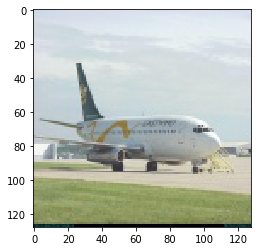

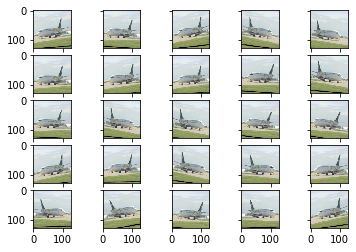

In [19]:
import albumentations as A

# INPUT/OUTPUT COLOR IN RANGE (0,1)
def AugmentOne(img):

    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(p=1.0, shift_limit=(-0.05, 0.05), scale_limit=(-0.05, 0.05), rotate_limit=(-10, 10), border_mode=4)
    ])
    
    img = 255 * img
    img = img.astype(np.uint8)

    transformed = transform(image=img)
    transformed_img = transformed["image"]
      
    transformed_img = transformed_img.astype('float32')
    transformed_img /= 255
    
    return transformed_img

# INPUT/OUTPUT COLOR IN RANGE (-1,1)
def AugmentMany(imgs):
    augmented_imgs = []
    for img in imgs:
        img = TanhToNormColor(img)
        img = AugmentOne(img)
        img = NormToTanhColor(img)
        augmented_imgs.append(img)
    return np.array(augmented_imgs)

def ShowAugmentation(img):
    plt.imshow(img, interpolation='nearest')
    plt.show()

    nrows = ncols = 5
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True,)
    for idx in range(nrows):    
      for jdx in range(ncols): 
        ax[idx,jdx].imshow(AugmentOne(img), interpolation='nearest')

ShowAugmentation(TanhToNormColor(x_test_real[0]))

EPOCH 1/200


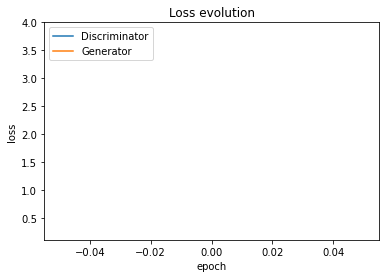

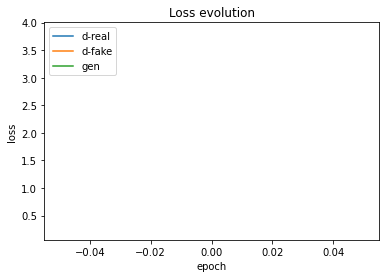

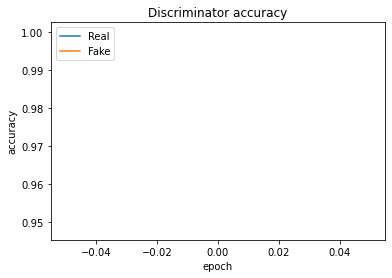

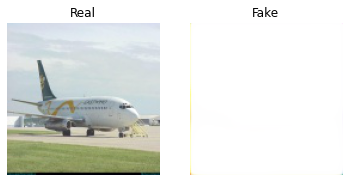

GENERATOR AT EPOCH 1:


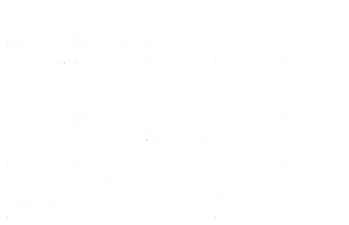

Generator model saved for epoch 1!
EPOCH 2/200
EPOCH 3/200s:0.5252 - gd_loss:2.34029
EPOCH 4/200s:0.5055 - gd_loss:2.0985
EPOCH 5/200s:0.3814 - gd_loss:1.6336
EPOCH 6/200s:0.4678 - gd_loss:1.7213
EPOCH 7/200s:0.4773 - gd_loss:1.7853
EPOCH 8/200s:0.5549 - gd_loss:1.5069
EPOCH 9/200s:0.4941 - gd_loss:1.5156
EPOCH 10/200:0.6305 - gd_loss:1.7442


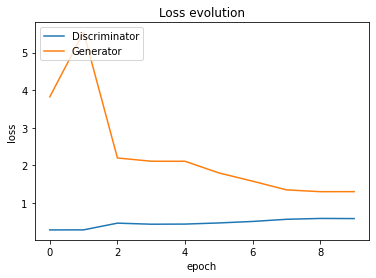

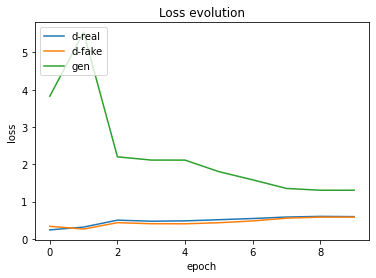

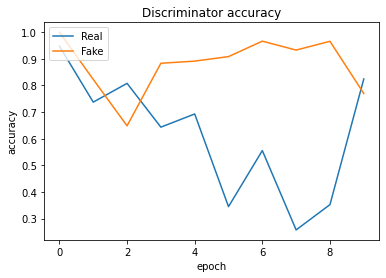

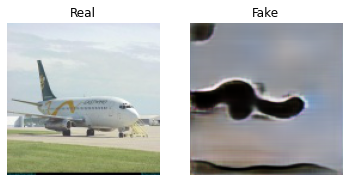

GENERATOR AT EPOCH 10:


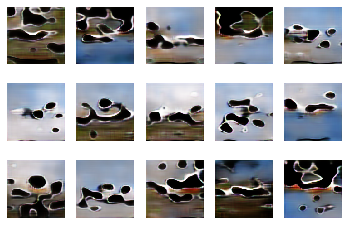

Generator model saved for epoch 10!
EPOCH 11/200
EPOCH 12/200:0.513 - gd_loss:2.22399
EPOCH 13/200:0.4329 - gd_loss:1.4633
EPOCH 14/200:0.5532 - gd_loss:1.9004
EPOCH 15/200:0.474 - gd_loss:1.55365
EPOCH 16/200:0.6013 - gd_loss:1.8506
EPOCH 17/200:0.3848 - gd_loss:1.5399
EPOCH 18/200:0.3842 - gd_loss:1.6761
EPOCH 19/200:0.5825 - gd_loss:1.5319
EPOCH 20/200:0.5147 - gd_loss:1.3903


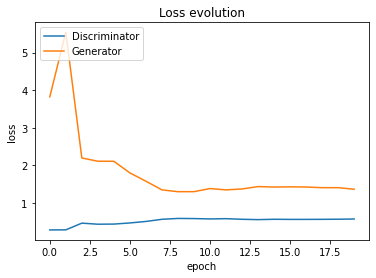

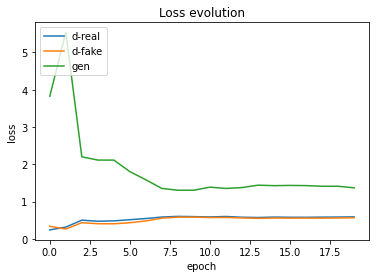

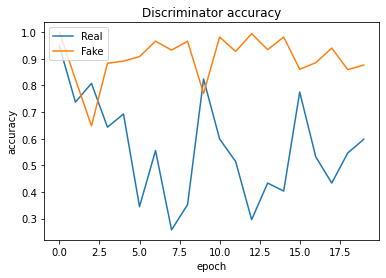

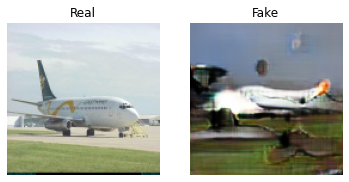

GENERATOR AT EPOCH 20:


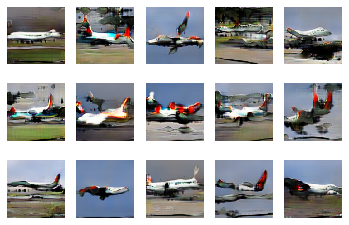

Generator model saved for epoch 20!
EPOCH 21/200
EPOCH 22/200:0.4175 - gd_loss:1.6025
EPOCH 23/200:0.4841 - gd_loss:1.7941
EPOCH 24/200:0.5808 - gd_loss:1.6434
EPOCH 25/200:0.5936 - gd_loss:1.9019
EPOCH 26/200:0.5651 - gd_loss:1.6584
EPOCH 27/200:0.4786 - gd_loss:1.7332
EPOCH 28/200:0.4734 - gd_loss:2.1288
EPOCH 29/200:0.3882 - gd_loss:1.7896
EPOCH 30/200:0.4611 - gd_loss:1.9799


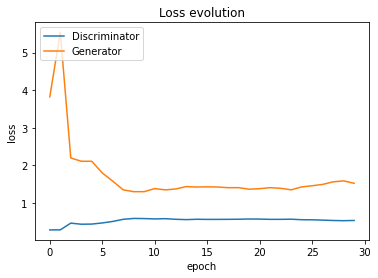

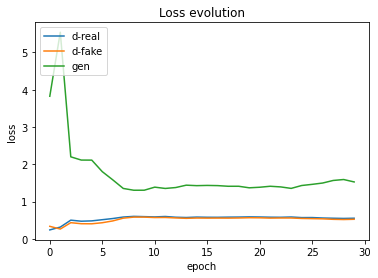

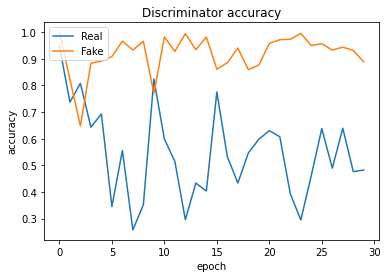

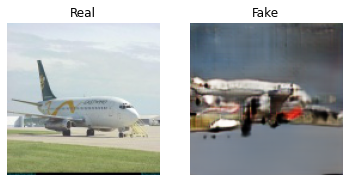

GENERATOR AT EPOCH 30:


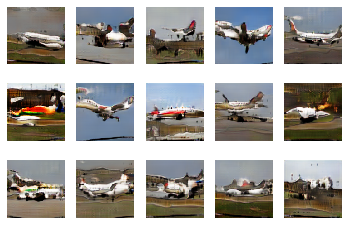

Generator model saved for epoch 30!
EPOCH 31/200
EPOCH 32/200:0.5128 - gd_loss:1.5055
EPOCH 33/200:0.4592 - gd_loss:1.7578
EPOCH 34/200:0.3925 - gd_loss:1.8571
EPOCH 35/200:0.4433 - gd_loss:1.6066
EPOCH 36/200:0.3577 - gd_loss:1.9473
EPOCH 37/200:0.417 - gd_loss:1.70095
EPOCH 38/200:0.4424 - gd_loss:1.9053
EPOCH 39/200:0.4489 - gd_loss:1.6944
EPOCH 40/200:0.4314 - gd_loss:1.6548


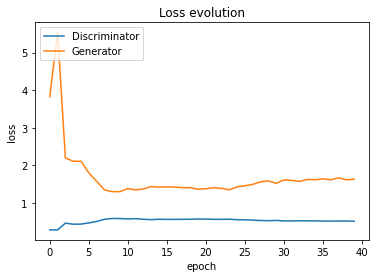

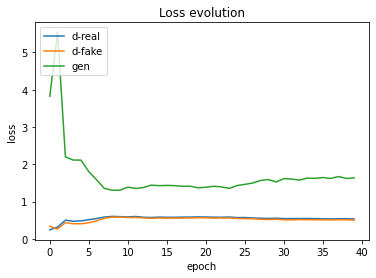

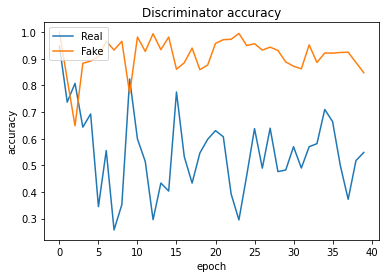

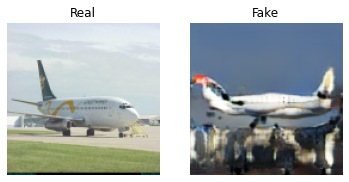

GENERATOR AT EPOCH 40:


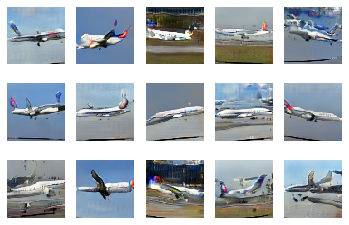

Generator model saved for epoch 40!
EPOCH 41/200
EPOCH 42/200:0.5839 - gd_loss:1.8237
EPOCH 43/200:0.5322 - gd_loss:1.8586
EPOCH 44/200:0.4093 - gd_loss:1.6319
EPOCH 45/200:0.5278 - gd_loss:1.7398
EPOCH 46/200:0.5231 - gd_loss:1.9665
EPOCH 47/200:0.6091 - gd_loss:1.8811
EPOCH 48/200:0.4336 - gd_loss:1.9799
EPOCH 49/200:0.4165 - gd_loss:1.9086
EPOCH 50/200:0.6071 - gd_loss:1.8416


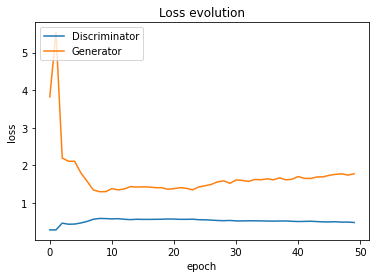

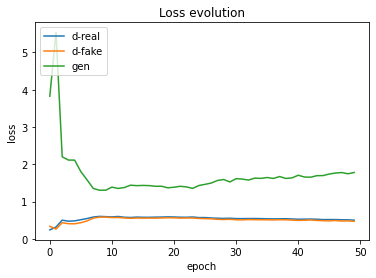

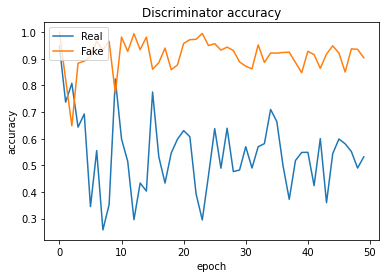

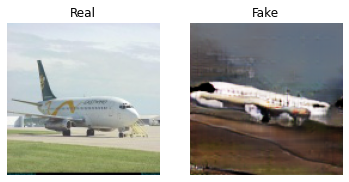

GENERATOR AT EPOCH 50:


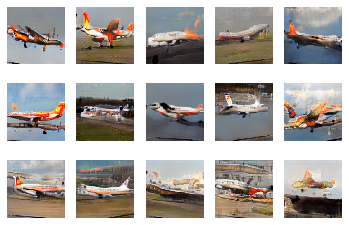

Generator model saved for epoch 50!
EPOCH 51/200
EPOCH 52/200:0.4319 - gd_loss:1.7126
EPOCH 53/200:0.3904 - gd_loss:1.5392
EPOCH 54/200:0.5011 - gd_loss:1.8932
EPOCH 55/200:0.4668 - gd_loss:1.8009
EPOCH 56/200:0.5193 - gd_loss:1.7974
EPOCH 57/200:0.4548 - gd_loss:1.7597
EPOCH 58/200:0.4391 - gd_loss:2.3026
EPOCH 59/200:0.4171 - gd_loss:2.0631
EPOCH 60/200:0.4238 - gd_loss:2.0323


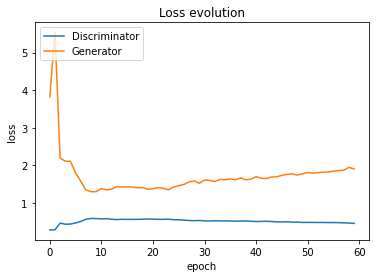

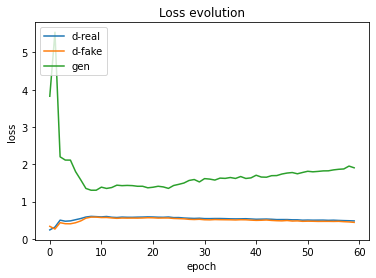

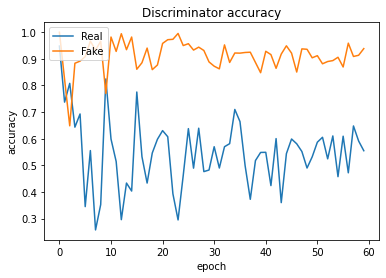

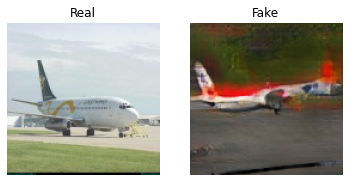

GENERATOR AT EPOCH 60:


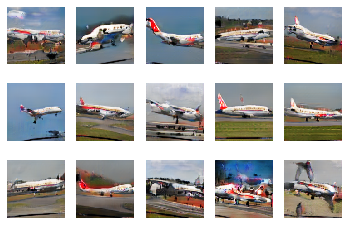

Generator model saved for epoch 60!
EPOCH 61/200
EPOCH 62/200:0.3607 - gd_loss:2.0098
EPOCH 63/200:0.3414 - gd_loss:2.1816
EPOCH 64/200:0.3625 - gd_loss:1.9582
EPOCH 65/200:0.338 - gd_loss:2.00381
EPOCH 66/200:0.5027 - gd_loss:2.1517
EPOCH 67/200:0.5038 - gd_loss:1.8974
EPOCH 68/200:0.3852 - gd_loss:2.3279
EPOCH 69/200:0.3618 - gd_loss:2.2256
EPOCH 70/200:0.4327 - gd_loss:1.9397


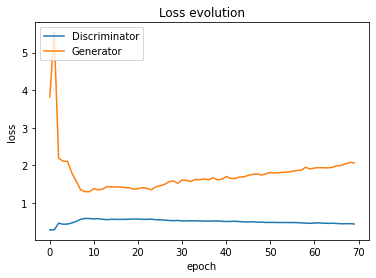

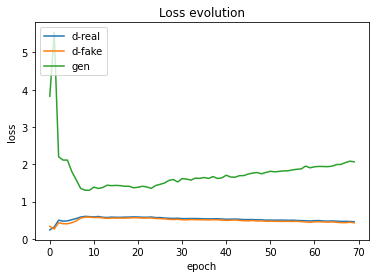

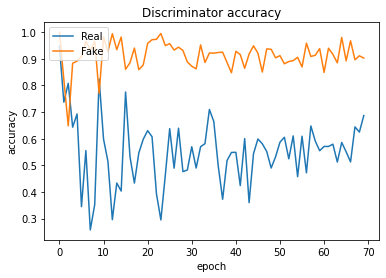

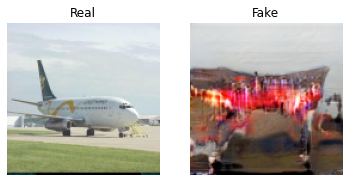

GENERATOR AT EPOCH 70:


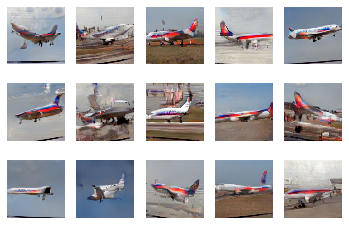

Generator model saved for epoch 70!
EPOCH 71/200
EPOCH 72/200:0.3659 - gd_loss:2.1382
EPOCH 73/200:0.3655 - gd_loss:2.2206
EPOCH 74/200:0.3646 - gd_loss:1.9055
EPOCH 75/200:0.263 - gd_loss:2.51243
EPOCH 76/200:0.3303 - gd_loss:2.1198
EPOCH 77/200:0.2915 - gd_loss:2.4574
EPOCH 78/200:0.4807 - gd_loss:2.4212
EPOCH 79/200:0.2687 - gd_loss:2.0027
EPOCH 80/200:0.3824 - gd_loss:2.3012


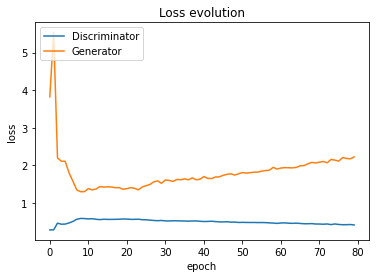

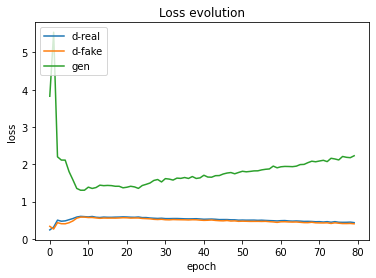

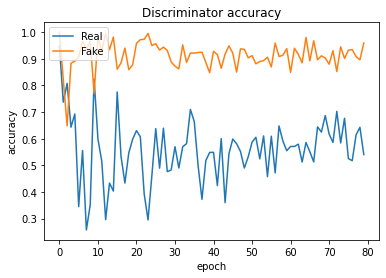

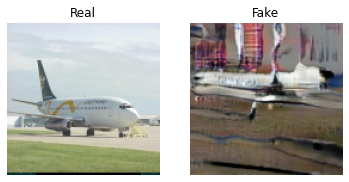

GENERATOR AT EPOCH 80:


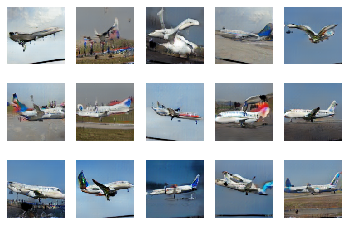

Generator model saved for epoch 80!
EPOCH 81/200
EPOCH 82/200:0.3783 - gd_loss:2.4075
EPOCH 83/200:0.4119 - gd_loss:2.7503
EPOCH 84/200:0.3741 - gd_loss:2.6472
EPOCH 85/200:0.3633 - gd_loss:2.1642
EPOCH 86/200:0.3159 - gd_loss:2.3269
EPOCH 87/200:0.286 - gd_loss:2.26916
EPOCH 88/200:0.389 - gd_loss:1.98827
EPOCH 89/200:0.2812 - gd_loss:2.6172
EPOCH 90/200:0.2366 - gd_loss:2.3877


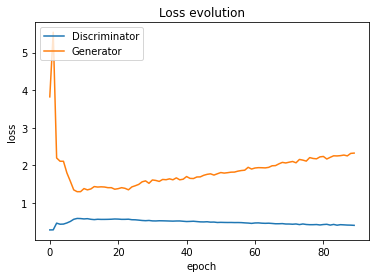

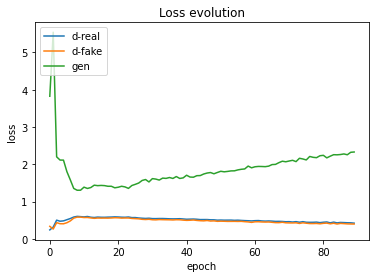

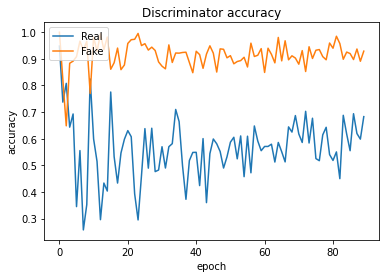

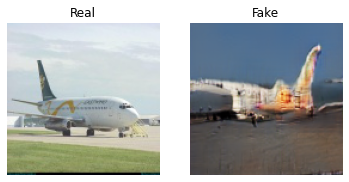

GENERATOR AT EPOCH 90:


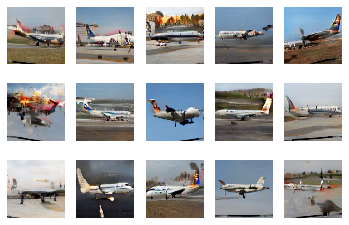

Generator model saved for epoch 90!
EPOCH 91/200
EPOCH 92/200:0.4438 - gd_loss:2.4052
EPOCH 93/200:0.2866 - gd_loss:2.5757
EPOCH 94/200:0.2595 - gd_loss:2.1172
EPOCH 95/200:0.2694 - gd_loss:2.7927
EPOCH 96/200:0.2514 - gd_loss:2.6165
EPOCH 97/200:0.3166 - gd_loss:2.4409
EPOCH 98/200:0.4237 - gd_loss:2.5581
EPOCH 99/200:0.3876 - gd_loss:2.4131
EPOCH 100/2000.3421 - gd_loss:2.1983


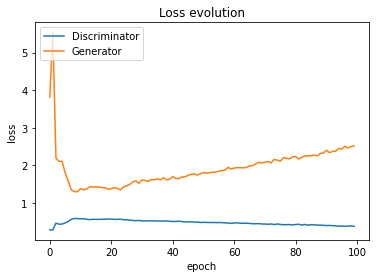

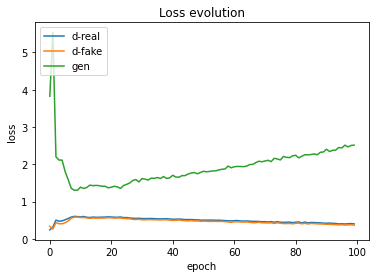

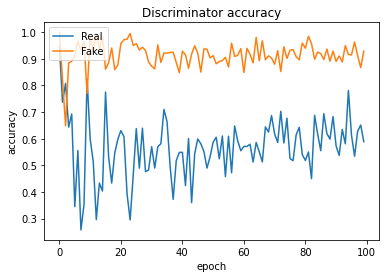

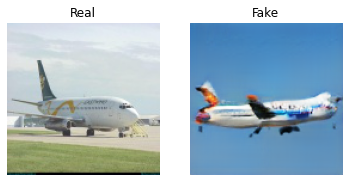

GENERATOR AT EPOCH 100:


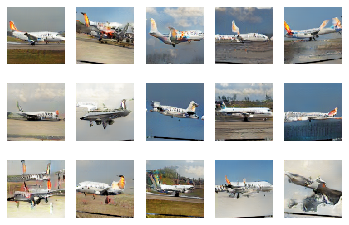

Generator model saved for epoch 100!
EPOCH 101/200
EPOCH 102/2000.1537 - gd_loss:2.9279
EPOCH 103/2000.1854 - gd_loss:2.7339
EPOCH 104/2000.1461 - gd_loss:2.2789
EPOCH 105/2000.2639 - gd_loss:2.9074
EPOCH 106/2000.219 - gd_loss:2.81157
EPOCH 107/2000.2632 - gd_loss:2.3454
EPOCH 108/2000.1688 - gd_loss:3.4024
EPOCH 109/2000.3543 - gd_loss:2.6807
EPOCH 110/2000.4549 - gd_loss:2.4237


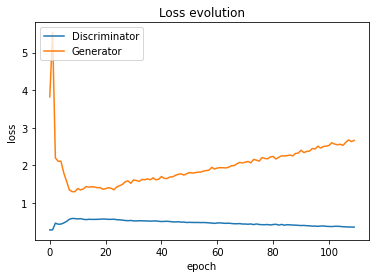

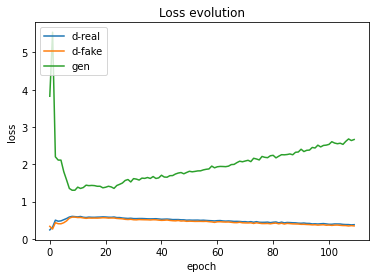

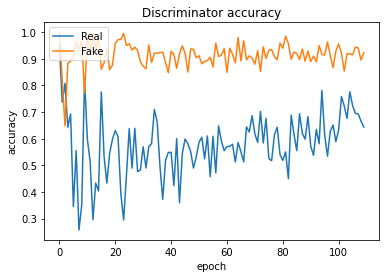

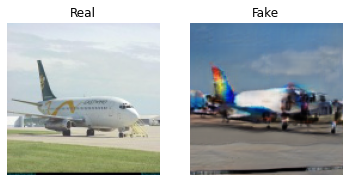

GENERATOR AT EPOCH 110:


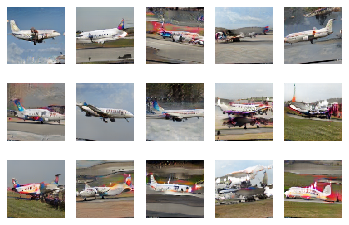

Generator model saved for epoch 110!
EPOCH 111/200
EPOCH 112/2000.2082 - gd_loss:3.0785
EPOCH 113/2000.1966 - gd_loss:2.7774
EPOCH 114/2000.4183 - gd_loss:2.9551
EPOCH 115/2000.2836 - gd_loss:3.0755
EPOCH 116/2000.336 - gd_loss:3.53754
EPOCH 117/2000.2281 - gd_loss:3.2366
EPOCH 118/2000.2259 - gd_loss:2.8829
EPOCH 119/2000.3721 - gd_loss:3.2419
EPOCH 120/2000.3456 - gd_loss:3.1236


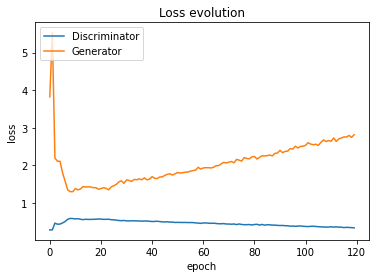

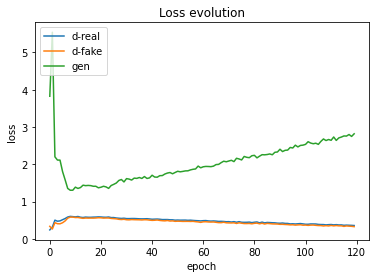

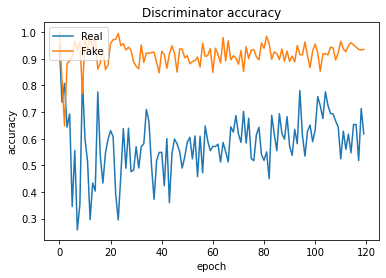

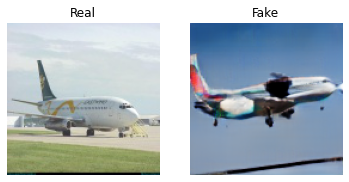

GENERATOR AT EPOCH 120:


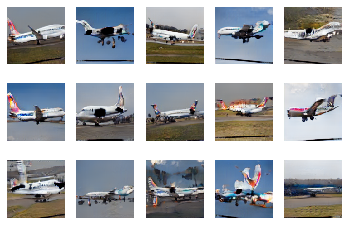

Generator model saved for epoch 120!
EPOCH 121/200
EPOCH 122/2000.3692 - gd_loss:2.5255
EPOCH 123/2000.1786 - gd_loss:3.6721
EPOCH 124/2000.2277 - gd_loss:2.5857
EPOCH 125/2000.2722 - gd_loss:3.1649
EPOCH 126/2000.3179 - gd_loss:2.4912
EPOCH 127/2000.287 - gd_loss:2.98393
EPOCH 128/2000.3511 - gd_loss:2.3805
EPOCH 129/2000.2041 - gd_loss:3.3093
EPOCH 130/2000.419 - gd_loss:3.29518


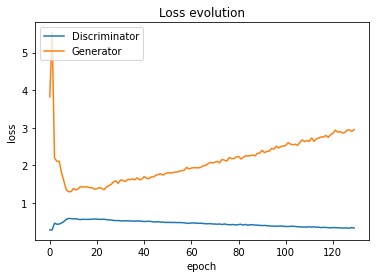

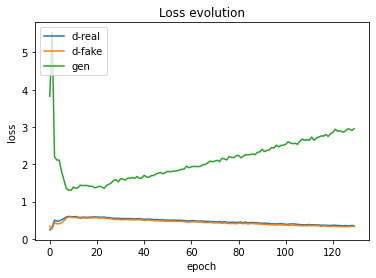

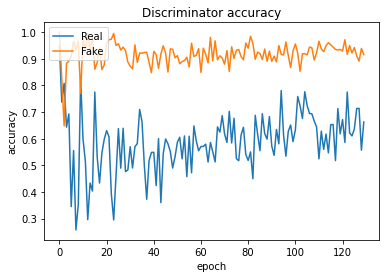

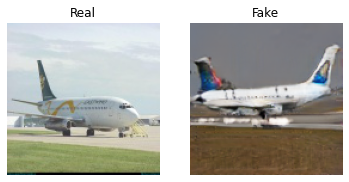

GENERATOR AT EPOCH 130:


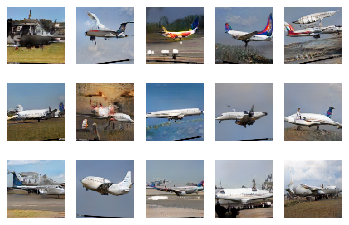

Generator model saved for epoch 130!
EPOCH 131/200
EPOCH 132/2000.2235 - gd_loss:3.0646
EPOCH 133/2000.3239 - gd_loss:3.4356
EPOCH 134/2000.2096 - gd_loss:3.5594
EPOCH 135/2000.2551 - gd_loss:3.9339
EPOCH 136/2000.3186 - gd_loss:3.6279
EPOCH 137/2000.1512 - gd_loss:4.2122
EPOCH 138/2000.3125 - gd_loss:3.0021
EPOCH 139/2000.2163 - gd_loss:3.7433
EPOCH 140/2000.3149 - gd_loss:3.7407


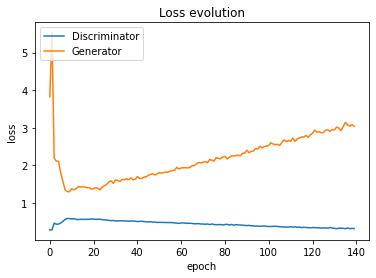

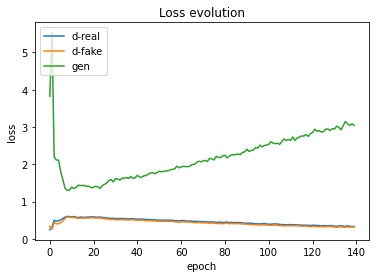

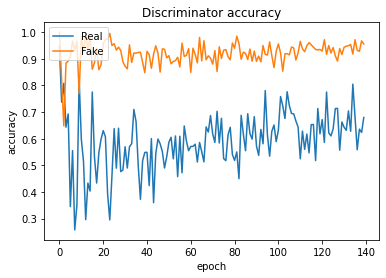

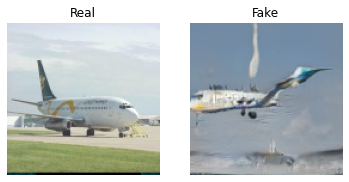

GENERATOR AT EPOCH 140:


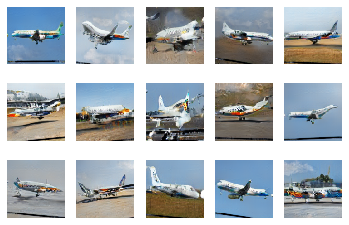

Generator model saved for epoch 140!
EPOCH 141/200
EPOCH 142/2000.291 - gd_loss:3.36926
EPOCH 143/2000.3508 - gd_loss:3.7301
EPOCH 144/2000.2612 - gd_loss:3.4687
EPOCH 145/2000.3651 - gd_loss:3.1285
EPOCH 146/2000.3941 - gd_loss:3.4654
EPOCH 147/2000.1748 - gd_loss:3.5768
EPOCH 148/2000.2798 - gd_loss:3.2013
EPOCH 149/2000.2406 - gd_loss:3.8663
EPOCH 150/2000.1995 - gd_loss:3.2596


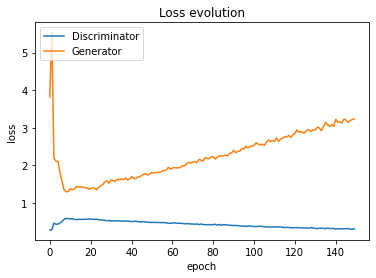

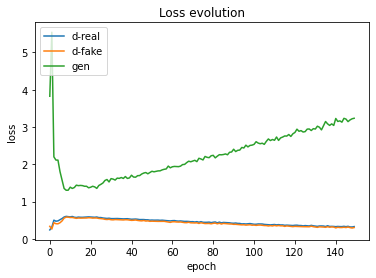

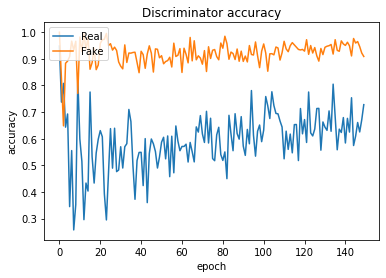

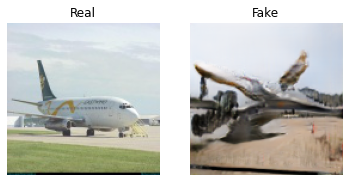

GENERATOR AT EPOCH 150:


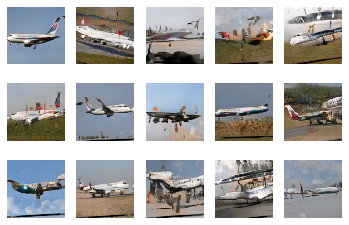

Generator model saved for epoch 150!
EPOCH 151/200
EPOCH 152/2000.411 - gd_loss:3.37998
EPOCH 153/2000.4627 - gd_loss:3.6133
EPOCH 154/2000.216 - gd_loss:3.34469
EPOCH 155/2000.3508 - gd_loss:4.1622
EPOCH 156/2000.3056 - gd_loss:3.3018
EPOCH 157/2000.2129 - gd_loss:2.7215
EPOCH 158/2000.3628 - gd_loss:3.7484
EPOCH 159/2000.2158 - gd_loss:4.6076
EPOCH 160/2000.1964 - gd_loss:4.0608


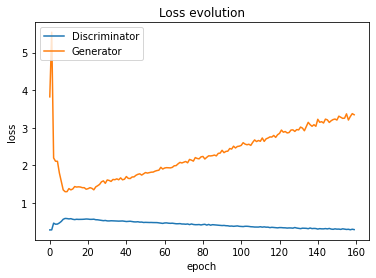

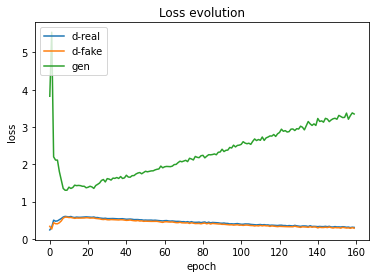

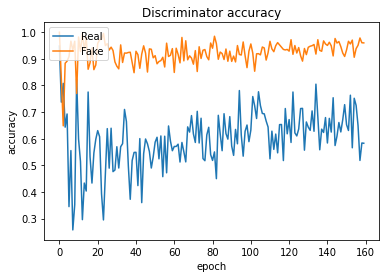

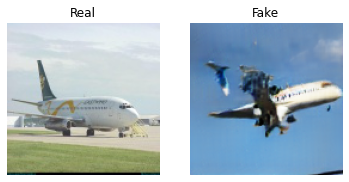

GENERATOR AT EPOCH 160:


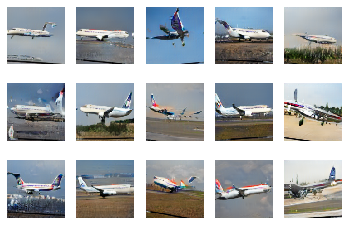

Generator model saved for epoch 160!
EPOCH 161/200
EPOCH 162/2000.2345 - gd_loss:3.8351
EPOCH 163/2000.31 - gd_loss:3.794482
EPOCH 164/2000.2958 - gd_loss:3.3961
EPOCH 165/2000.1888 - gd_loss:3.8548
EPOCH 166/2000.1774 - gd_loss:3.3131
EPOCH 167/2000.4136 - gd_loss:3.3868
EPOCH 168/2000.2181 - gd_loss:4.1015
EPOCH 169/2000.1404 - gd_loss:3.8004
EPOCH 170/2000.0969 - gd_loss:4.2988


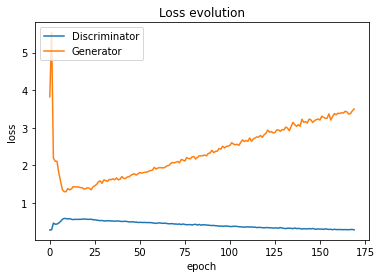

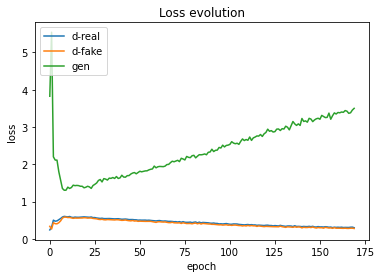

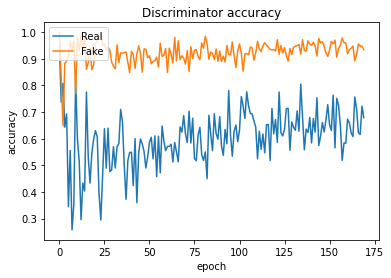

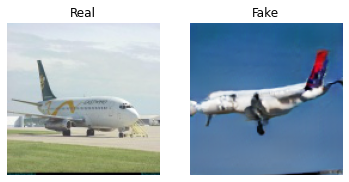

GENERATOR AT EPOCH 170:


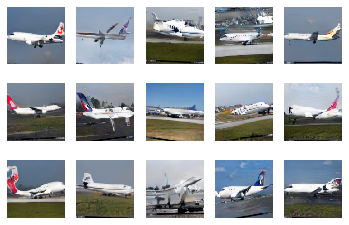

Generator model saved for epoch 170!
EPOCH 171/200
EPOCH 172/2000.2164 - gd_loss:4.0105
EPOCH 173/2000.2616 - gd_loss:3.4783
EPOCH 174/2000.1605 - gd_loss:2.8086
EPOCH 175/2000.156 - gd_loss:4.30851
EPOCH 176/2000.3163 - gd_loss:3.3485
EPOCH 177/2000.2552 - gd_loss:4.5482
EPOCH 178/2000.226 - gd_loss:3.27412
EPOCH 179/2000.1429 - gd_loss:3.5219
EPOCH 180/2000.3282 - gd_loss:3.6067


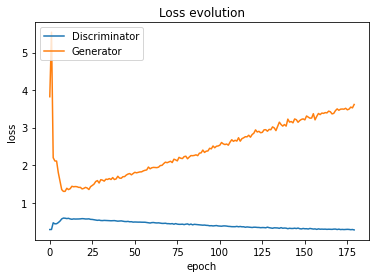

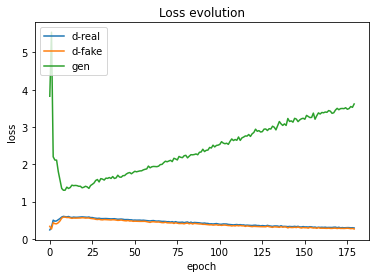

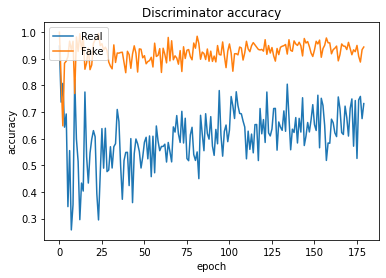

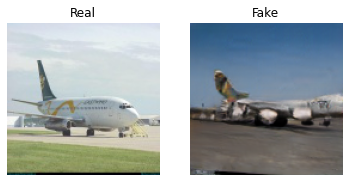

GENERATOR AT EPOCH 180:


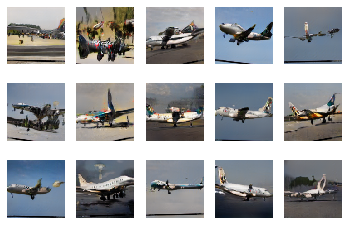

Generator model saved for epoch 180!
EPOCH 181/200
EPOCH 182/2000.1248 - gd_loss:3.6981
EPOCH 183/2000.1539 - gd_loss:3.3669
EPOCH 184/2000.2045 - gd_loss:4.2529
EPOCH 185/2000.1729 - gd_loss:3.5202
EPOCH 186/2000.1553 - gd_loss:4.6821
EPOCH 187/2000.2256 - gd_loss:4.8122
EPOCH 188/2000.3528 - gd_loss:3.7404
EPOCH 189/2000.1267 - gd_loss:3.8451
EPOCH 190/2000.1644 - gd_loss:3.6675


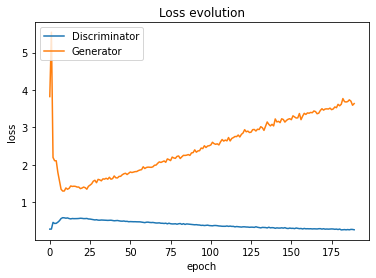

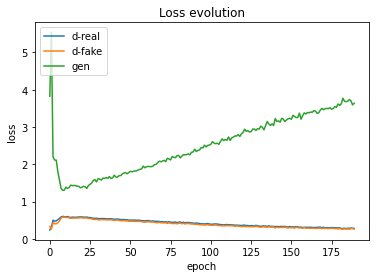

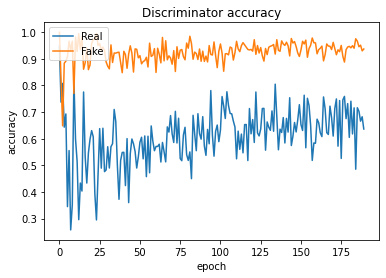

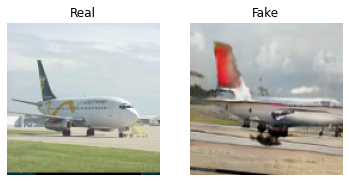

GENERATOR AT EPOCH 190:


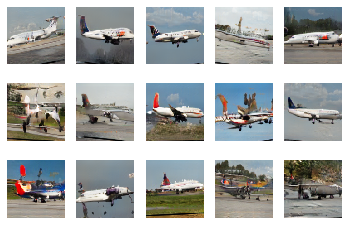

Generator model saved for epoch 190!
EPOCH 191/200
EPOCH 192/2000.1442 - gd_loss:4.3497
EPOCH 193/2000.2338 - gd_loss:4.0782
EPOCH 194/2000.2975 - gd_loss:4.1437
EPOCH 195/2000.1112 - gd_loss:3.9268
EPOCH 196/2000.118 - gd_loss:3.59512
EPOCH 197/2000.1406 - gd_loss:4.1969
EPOCH 198/2000.1466 - gd_loss:5.0789
EPOCH 199/2000.2498 - gd_loss:5.3523
EPOCH 200/2000.1475 - gd_loss:4.3763


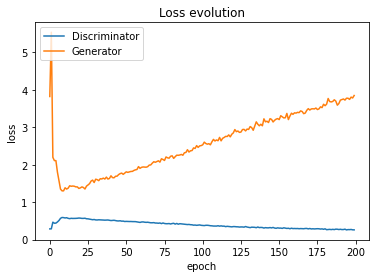

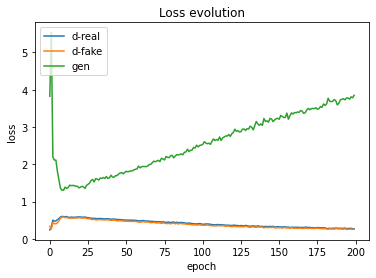

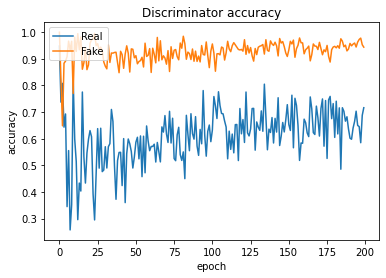

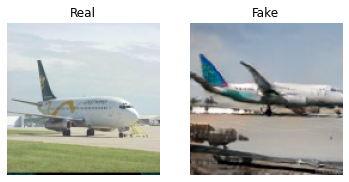

GENERATOR AT EPOCH 200:


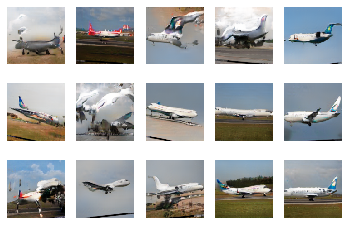

Generator model saved for epoch 200!


In [20]:
# TRAIN

len_train_files = len(train_files)
real_samples_per_batch = int(batch_size/2)
batches_of_train_files = [train_files[i:i + real_samples_per_batch] for i in range(0, len_train_files, real_samples_per_batch)]

batch_per_epoch = int((len_train_files*2)/batch_size)

history = {
    "epochs":np.array([]),
    "avg_d_loss":[],
    "avg_gd_loss":[],
    "d_acc_real":[],
    "d_acc_fake":[]
}

for e in range(epochs):
    
    print(f'EPOCH {e+1}/{epochs}')
    
    epoch_history = {
        "d_loss":[],
        "d_loss_real":[],
        "d_loss_fake":[],
        "gd_loss":[]
    }
    
    for b in range(batch_per_epoch):
        
        # GET IMAGES
        
        x_train_real_batch = LoadImagesFromFolder(train_folder, batches_of_train_files[b])

        x_train_real_batch = x_train_real_batch.astype('float32')
        # Normalize [0..255]-->[-1..1] as we use tanh activation function
        x_train_real_batch = (x_train_real_batch - 127.5) / 127.5
        
        # APPLY DA
        x_train_real_batch = AugmentMany(x_train_real_batch)
        
        # TRAIN DISCRIMINATOR
        
        y_train_real_batch = np.ones(len(x_train_real_batch))
        
        x_train_fake_batch = GetFakeSamples(g_model, latent_dim, int(batch_size/2))
        y_train_fake_batch = np.zeros(len(x_train_fake_batch))
        
        d_loss_real, _ = d_model.train_on_batch(x_train_real_batch, y_train_real_batch)
        d_loss_fake, _ = d_model.train_on_batch(x_train_fake_batch, y_train_fake_batch) 
        d_loss = (d_loss_real+d_loss_fake)/2.0

        # TRAIN GD
        
        rnd_values = randn(latent_dim * batch_size)
        
        x_train = rnd_values.reshape(batch_size, latent_dim)        
        y_train = np.ones(len(x_train))
        
        gd_loss = gd_model.train_on_batch(x_train, y_train)
        
        print(f'{int((b/batch_per_epoch)*100)}% - d_loss:{np.round(d_loss,4)} - gd_loss:{np.round(gd_loss,4)}', end='\r')
        
        # HISTORY
        epoch_history["d_loss"].append(d_loss)
        epoch_history["d_loss_real"].append(d_loss_real)
        epoch_history["d_loss_fake"].append(d_loss_fake)
        epoch_history["gd_loss"].append(gd_loss)
        
    # HISTORY
    history["epochs"] = np.append(history["epochs"], epoch_history)
    history["avg_d_loss"].append(statistics.mean(epoch_history["d_loss"]))
    history["avg_gd_loss"].append(statistics.mean(epoch_history["gd_loss"]))
    
    x_test_fake = GetFakeSamples(g_model, latent_dim, len(x_test_real))   
    d_acc_real, d_acc_fake = GetDiscriminatorPerformance(d_model, x_test_real, x_test_fake)
    
    history["d_acc_real"].append(d_acc_real)
    history["d_acc_fake"].append(d_acc_fake)
    
    if e == 0 or (e+1) % 10 == 0:
        
        d_loss_real = [statistics.mean(e['d_loss_real']) for e in history['epochs']]
        d_loss_fake = [statistics.mean(e['d_loss_fake']) for e in history['epochs']]
        g_loss = [statistics.mean(e['gd_loss']) for e in history['epochs']]

        PlotLossA(history['avg_d_loss'],history['avg_gd_loss'])
        PlotLossB(d_loss_real, d_loss_fake, g_loss)
        PlotAccuracy(history['d_acc_real'],history['d_acc_fake'])
        
        PlotRealFakeComparison(x_test_real[0], x_test_fake[0])
        
        ShowGeneratorPerformance(g_model, e+1, latent_dim, rows=3, columns=5)
        SaveGeneratorModel(e+1, g_model)